# This notebook classifies naturalized flows from all realizations according to several metrics based on the drought classification in Ault et al. (2014)

## Used to create Fig. 3

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math

Read in **naturalized** historic flows, make annual and convert to metric

In [3]:
historic_flows = np.load('../streamflow_data/historic_flows.npy')
annual_historic_flows = np.sum(historic_flows, axis=1)*1233.4818/1000000

Calculate mean and standard deviation

In [4]:
mean_flow = np.mean(annual_historic_flows)
st_deviation = np.std(annual_historic_flows)
drought_threshold = mean_flow-0.5*st_deviation

Identify decadal droughts

In [5]:
#script from https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/
window_size = 11

i = 0
# Initialize an empty list to store moving averages
moving_averages = []

# Loop through the array to consider
# every window of size 3
while i < len(annual_historic_flows) - window_size + 1:
    # Store elements from i to i+window_size
    # in list to get the current window
    window = annual_historic_flows[i : i + window_size]

    # Calculate the average of current window
    window_average = round(sum(window) / window_size, 2)
    
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
    
    # Shift window to right by one position
    i += 1


Plot windows in flow figure

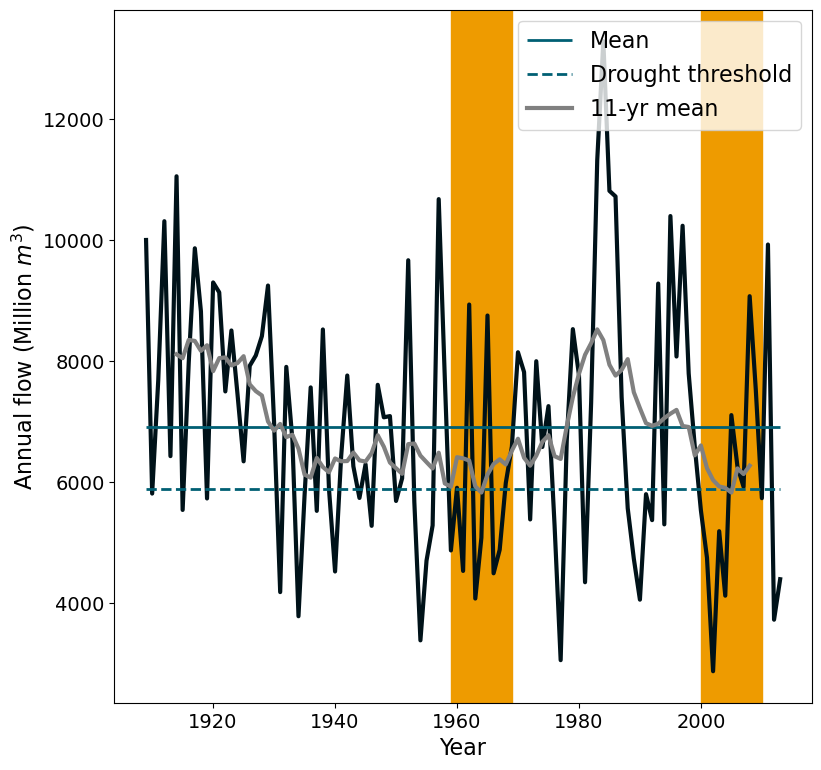

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(9,9))
ax.plot(np.arange(1909, 2014), annual_historic_flows, linewidth=3, color='#001219')
ax.hlines(y=mean_flow, xmin=1909, xmax=2013, linewidth=2, color='#005F73', label='Mean')
ax.hlines(y=drought_threshold, xmin=1909, xmax=2013, linewidth=2, 
          linestyle='--', color='#005F73', label='Drought threshold')
highlight_years=np.arange(1914, 2009)[moving_averages < drought_threshold]
for year in highlight_years:
    #the window to highlight is +/- 5 years from the identified year crossing the threshold
    ax.axvspan(year-5, year+5, color='#EE9B00') 
ax.plot(np.arange(1914, 2009), moving_averages, linewidth=3, color='grey', label='11-yr mean')

ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel("Annual flow (Million $m^3$)", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.legend(fontsize=16, loc='upper right')
plt.savefig('historic_droughts.svg')

Read in flows from stationary sample

In [7]:
stationary_flows = np.load('../streamflow_data/stationarysynthetic_flows.npy')*1233.4818/1000000
annual_stationary_flows = np.sum(stationary_flows, axis=2)

Edit figure to show both decadal and multi-decadal

In [8]:
def drought_identification_plots(timeseries, drought_threshold, filename, decadal_window=11, multidecadal_window=35):   
    drought_windows=[multidecadal_window, decadal_window]
    drought_colors=[ '#CA6702', '#EE9B00']
    all_years = len(timeseries)

    fig = plt.figure(figsize=(6,9))
    # parameters to specify the width and height ratios between rows and columns
    widths= [1]
    heights = [5, 1]

    gspec = fig.add_gridspec(ncols=1, nrows=2, width_ratios = widths, height_ratios = heights)
    ax = fig.add_subplot(gspec[0,0])
    ax.plot(np.arange(all_years), timeseries, linewidth=3, color='#001219')
    ax.hlines(y=mean_flow, xmin=0, xmax=len(timeseries), linewidth=2, color='#005F73', label='Mean')
    ax.hlines(y=drought_threshold, xmin=0, xmax=len(timeseries), linewidth=2, 
              linestyle='--', color='#005F73', label='Drought threshold')
    
    #Create list to store drought totals
    all_drought_years=[]
    
    for w in range(len(drought_windows)):
        window_size = drought_windows[w]
        #Calculate rolling means for each drought window
        i = 0
        # Initialize an empty list to store moving averages
        moving_averages = []

        # Loop through the array to consider
        # every window of size 3
        while i < len(timeseries) - window_size + 1:
            # Store elements from i to i+window_size
            # in list to get the current window
            window = timeseries[i : i + window_size]

            # Calculate the average of current window
            window_average = round(sum(window) / window_size, 2)

            # Store the average of current
            # window in moving average list
            moving_averages.append(window_average)

            # Shift window to right by one position
            i += 1

        #Plot results
        half_window = math.floor(window_size/2)

        highlight_years=np.arange(half_window, all_years-half_window)[moving_averages < drought_threshold]
        all_drought_years_in_window = []
        for year in highlight_years:
            first_year = year-half_window
            last_year = year+half_window
            #the window to highlight is +/- 5 years from the identified year crossing the threshold
            ax.axvspan(first_year, last_year, color=drought_colors[w]) 
            ax.plot(np.arange(half_window, all_years-half_window), 
                    moving_averages, linewidth=3, color='grey', label=f'{window_size}-yr mean')
            all_drought_years_in_window.extend(np.arange(first_year, last_year+1))
    
        all_drought_years.append(set(all_drought_years_in_window))
    # remove decadal drought years that also appear in multidecadal
    all_drought_years[1]=set(all_drought_years[1]) - set(all_drought_years[0])
    # lenght of multidecadal set and then length of decadal set
    total_drought_years = [len(years_list) for years_list in all_drought_years]
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylabel("Annual flow (Million $m^3$)", fontsize=16)
    ax.set_xlabel("Year in realization", fontsize=16)
    
    plt.savefig(filename)
    return(total_drought_years)

[0, 38]

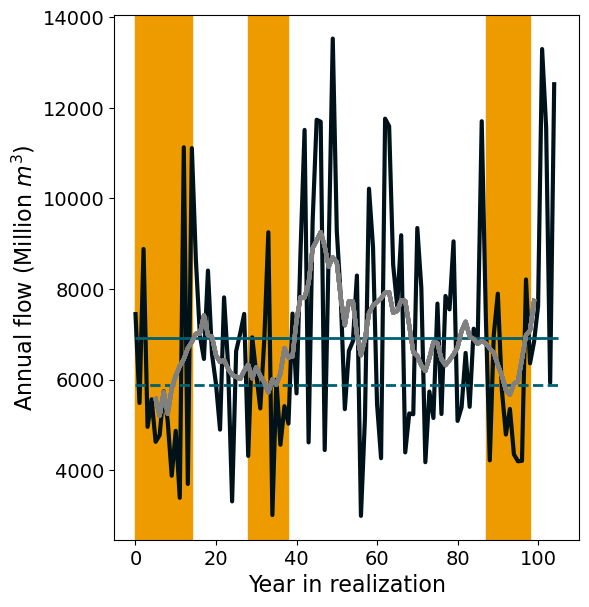

In [9]:
drought_identification_plots(annual_stationary_flows[3], drought_threshold, 'synthetic_droughts_a.svg')